In [1]:
from torch import tensor, Tensor, matrix_power, zeros
import torch


In [2]:
edge_list = [
    (1, 0),
    (2, 0),
    (3, 1),
    (3, 2),
    (4, 1),
    (4, 2),
    (5, 1),
    (5, 2),
    (6, 3),
    (6, 4),
    (6, 5),
    (7, 3),
    (7, 4),
    (7, 5),
    (8, 6),
    (8, 7)
]

adjacency_matrix = zeros(9, 9)

for src, dst in edge_list:
    adjacency_matrix[src, dst] = 1

Tensor.fill_diagonal_(adjacency_matrix, 1)


tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 1., 1., 0., 0., 0., 0., 0.],
        [0., 1., 1., 0., 1., 0., 0., 0., 0.],
        [0., 1., 1., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 1., 1., 1., 0., 0.],
        [0., 0., 0., 1., 1., 1., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 1., 1., 1.]])

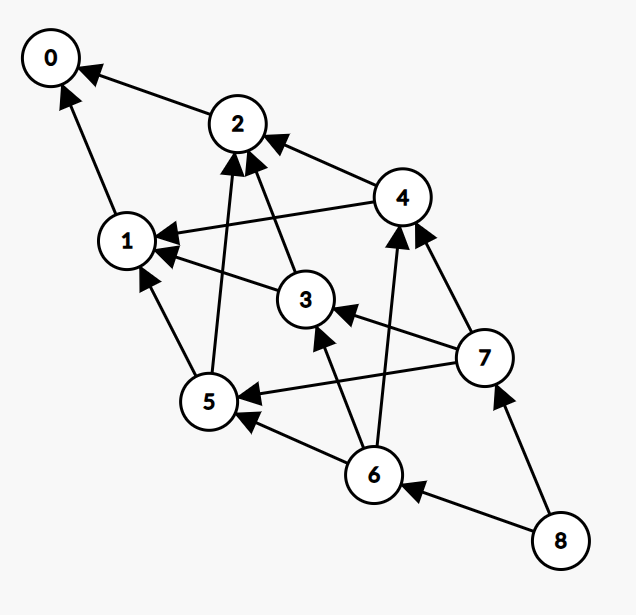

In [3]:
edge_list = [
    (1, 0),
    (2, 0),
    (3, 1),
    (3, 2),
    (4, 1),
    (4, 2),
    (5, 1),
    (5, 2),
]

adjacency_matrix = zeros(6, 6)

for src, dst in edge_list:
    adjacency_matrix[src, dst] = 1

Tensor.fill_diagonal_(adjacency_matrix, 1)


tensor([[1., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0.],
        [1., 0., 1., 0., 0., 0.],
        [0., 1., 1., 1., 0., 0.],
        [0., 1., 1., 0., 1., 0.],
        [0., 1., 1., 0., 0., 1.]])

In [4]:
matrix_power(adjacency_matrix, 4)

tensor([[ 1.,  0.,  0.,  0.,  0.,  0.],
        [ 4.,  1.,  0.,  0.,  0.,  0.],
        [ 4.,  0.,  1.,  0.,  0.,  0.],
        [12.,  4.,  4.,  1.,  0.,  0.],
        [12.,  4.,  4.,  0.,  1.,  0.],
        [12.,  4.,  4.,  0.,  0.,  1.]])

In [141]:
from torch_geometric.datasets import Planetoid
from torch_geometric.utils import k_hop_subgraph


cora_dataset = Planetoid(root='/tmp/Cora', name='Cora')
citeseer_dataset = Planetoid(root='/tmp/CiteSeer', name='CiteSeer')
pubmed_dataset = Planetoid(root='/tmp/PubMed', name='PubMed')

cora_data = cora_dataset[0]
citeseer_data = citeseer_dataset[0]
pubmed_data = pubmed_dataset[0]

def get_subgraph_from_node(node_id, r, data=cora_data):
    subgraph_indices, edge_index, mapping, edge_mask = k_hop_subgraph(
        node_id, r, data.edge_index, relabel_nodes=False)

    subgraph = data.subgraph(subgraph_indices)

    return subgraph, edge_index



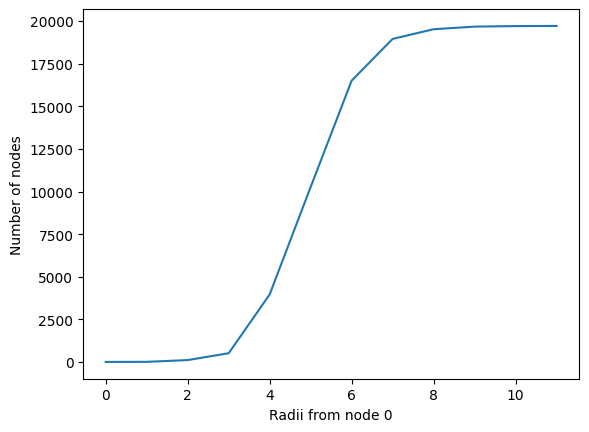

In [168]:
from matplotlib import pyplot as plt

def plot_rached_nodes(depth, data, node=0):
    x = torch.arange(0, depth)
    y = [get_subgraph_from_node(node, i, data=data)[0].x.shape[0] for i in x]

    plt.xlabel(f'Radii from node {node}')
    plt.ylabel('Number of nodes')
    plt.plot(x, y)
    plt.savefig(f'results/test.svg')
    plt.show()

plot_rached_nodes(12, data=pubmed_data, node=0)


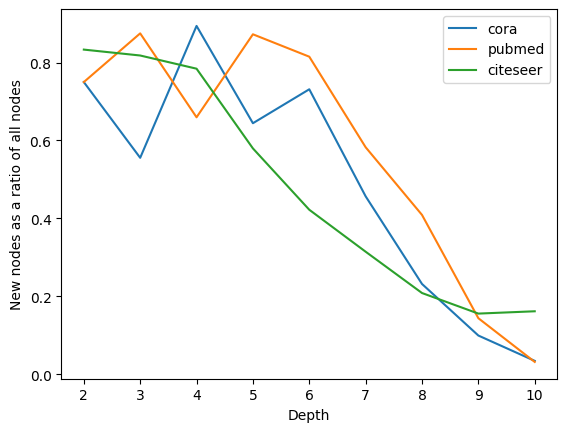

In [198]:
def plot_receptive_field_growth(depth, data_list, node=0):

    for key, dataset in zip(["cora", "pubmed", "citeseer"], data_list):
        x = torch.arange(0, depth)
        number_nodes = [get_subgraph_from_node(node, i, data=dataset)[0].x.shape[0] for i in x]
        y = [(number_nodes[i]-number_nodes[i-1])/number_nodes[i] for i in range(1,len(number_nodes))]
        plt.plot(x[1:]+1, y, label=key)

    plt.legend()
    plt.xlabel("Depth")
    plt.ylabel("New nodes as a ratio of all nodes")
    plt.savefig("results/receptive-field-grow-node-{}.svg".format(node))
    plt.show()

plot_receptive_field_growth(10, data_list=[cora_data, pubmed_data, citeseer_data], node=1)

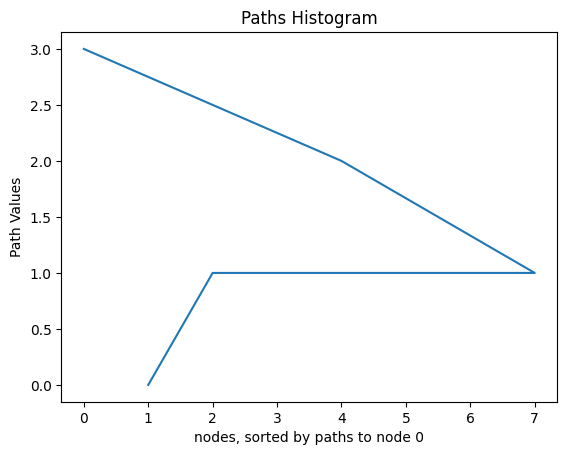

In [195]:
from torch_geometric.utils import to_dense_adj

def plot_paths_histogram(layers, node=0, data=cora_data):
    subgraph, edge_idx = get_subgraph_from_node(node, layers, data)

    adjm = to_dense_adj(subgraph.edge_index)[0]
    x = subgraph.edge_index.unique().squeeze(0).numpy()
    y = matrix_power(adjm, layers)[0].squeeze(0)

    # Sort x according to the order of y
    sorted_indices = torch.argsort(y)
    x_sorted = x[sorted_indices].astype(int)  # Ensure x is integers
    y_sorted = y[sorted_indices]

    plt.plot(x_sorted, y_sorted)
    
    # Set x-ticks to only show integers
    plt.xticks(ticks=x_sorted, labels=x_sorted)
    
    # Label the x-axis
    plt.xlabel(f'nodes, sorted by paths to node {node}')
    
    # Optional: Add labels for y-axis and title
    plt.ylabel('Path Values')  # Change as needed
    plt.title('Paths Histogram')  # Change as needed
    
    plt.show()

plot_paths_histogram(2, node=0, data=cora_data)

In [98]:
edge_pairs = zip(subgraph.edge_index[0], subgraph.edge_index[1])

for pair in edge_pairs:
    print(pair[0].item(), pair[1].item())

1 0
2 0
3 0
0 1
0 2
3 2
0 3
2 3


In [68]:
# convert edge list to adjacency matrix

adjacency_matrix = torch.zeros(len(subgraph.x), len(subgraph.x))

edge_pairs = zip(subgraph.edge_index[0], subgraph.edge_index[1])

for pair in edge_pairs:
    adjacency_matrix[pair[0], pair[1]] = 1
print(adjacency_matrix[0])
print(adjacency_matrix[:, 0])
matrix_power(adjacency_matrix, 2)[1]


tensor([0., 1., 0., 0., 1., 1., 0., 0., 0.])
tensor([0., 1., 0., 0., 1., 1., 0., 0., 0.])


tensor([0., 5., 0., 0., 1., 1., 0., 0., 0.])

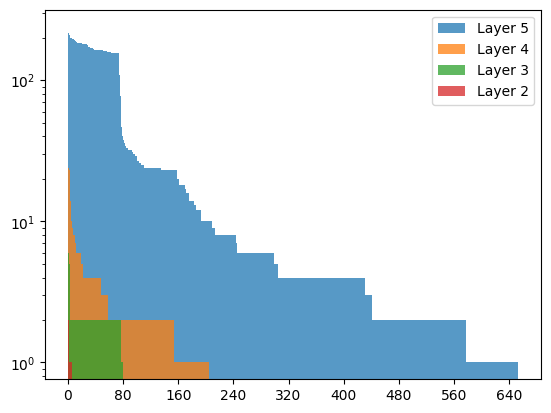

In [253]:

from matplotlib.ticker import MaxNLocator


def plot_node_paths(depth_range, data, node=0, scale="log"):
    for layer in range(depth_range[0], depth_range[1]):
        layer = depth_range[0] + (depth_range[1] - layer)
        subgraph, edge_idx = get_subgraph_from_node(node, layer, data)

        x = subgraph.edge_index.unique().squeeze(0).numpy()
        adjm = to_dense_adj(subgraph.edge_index)[0]
        y = matrix_power(adjm, layer)[node].squeeze(0)
        y = y[torch.argsort(y, descending=True)]

        plt.bar(x, y, label=f'Layer {layer}', alpha=0.75, width=1, align='center')
        plt.legend()
    
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    if scale == "log":
        plt.yscale('log')
    plt.savefig(f'results/cora-paths-layer-{depth_range[0]}-{depth_range[1]}.svg')
    plt.show()

plot_node_paths([1,5], data=cora_data, node=0)

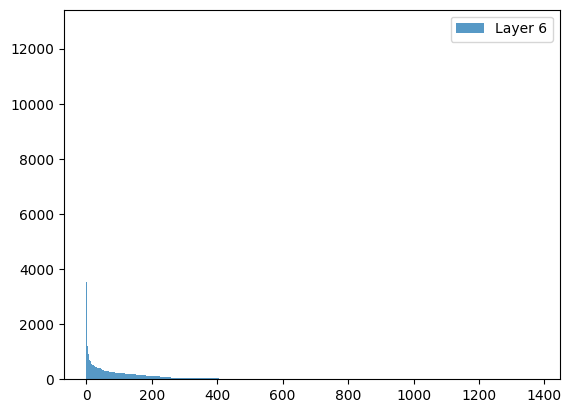

In [257]:
plot_node_paths([5,6], data=cora_data, node=0, scale=None)